Colating the Swift photometry from LTT1445, might add some Phoenix models as well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from craftroom import resample
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/'

In [3]:
phots = glob.glob('{}*phot*.fits'.format(path))
phots

['/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445A_phot_uvm2_obs1.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445A_phot_uvm2_obs2.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445A_phot_u_obs3.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445BC_phot_uvm2_obs1.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445BC_phot_uvm2_obs2.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445BC_phot_u_obs3.fits']

In [4]:
for phot in phots:
    data = fits.getdata(phot, 1)
data.names

['MET',
 'EXTNAME',
 'TSTART',
 'TSTOP',
 'EXPOSURE',
 'TELAPSE',
 'TIME',
 'SRC_AREA',
 'BKG_AREA',
 'STD_AREA',
 'PLATE_SCALE',
 'RAW_TOT_CNTS',
 'RAW_TOT_CNTS_ERR',
 'RAW_BKG_CNTS',
 'RAW_BKG_CNTS_ERR',
 'RAW_STD_CNTS',
 'RAW_STD_CNTS_ERR',
 'RAW_TOT_RATE',
 'RAW_TOT_RATE_ERR',
 'RAW_BKG_RATE',
 'RAW_BKG_RATE_ERR',
 'RAW_STD_RATE',
 'RAW_STD_RATE_ERR',
 'COI_STD_FACTOR',
 'COI_STD_FACTOR_ERR',
 'COI_BKG_FACTOR',
 'COI_BKG_FACTOR_ERR',
 'COI_TOT_RATE',
 'COI_TOT_RATE_ERR',
 'COI_BKG_RATE',
 'COI_BKG_RATE_ERR',
 'COI_SRC_RATE',
 'COI_SRC_RATE_ERR',
 'AP_FACTOR',
 'AP_FACTOR_ERR',
 'AP_COI_SRC_RATE',
 'AP_COI_SRC_RATE_ERR',
 'LSS_FACTOR',
 'LSS_RATE',
 'LSS_RATE_ERR',
 'SENSCORR_FACTOR',
 'SENSCORR_RATE',
 'SENSCORR_RATE_ERR',
 'CORR_RATE',
 'CORR_RATE_ERR',
 'AB_MAG',
 'AB_MAG_ERR',
 'AB_MAG_ERR_STAT',
 'AB_MAG_ERR_SYS',
 'AB_MAG_BKG',
 'AB_MAG_BKG_ERR_STAT',
 'AB_MAG_BKG_ERR_SYS',
 'AB_MAG_BKG_ERR',
 'AB_MAG_LIM',
 'AB_MAG_LIM_SIG',
 'AB_MAG_COI_LIM',
 'AB_FLUX_AA',
 'AB_FLUX_AA_ERR_

In [5]:
for phot in phots:
    data = fits.getdata(phot, 1)
    print(data['FILTER'])

['UVM2']
['UVM2']
['U']
['UVM2']
['UVM2']
['U']


In [6]:
cenwaves = dict(V=5468, B=4392, U=3465,UVW1=2600, UVM2=2246, UVW2=1928)
fwhms = dict(V=769, B=975, U=785, UVW1=693, UVM2=498, UVW2=657)


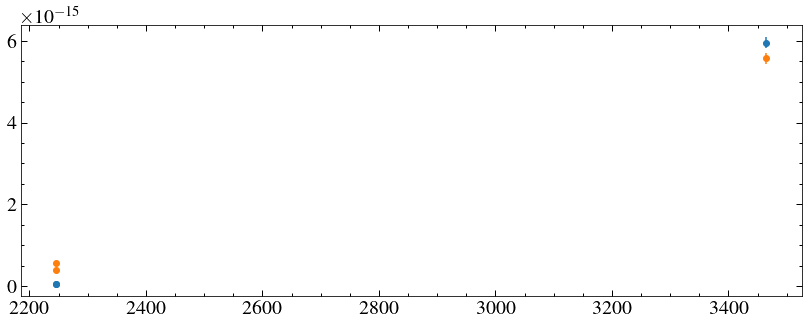

In [7]:
for phot in phots:
    data = fits.getdata(phot, 1)
    w = cenwaves[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    c= 'C0'
    if 'BC' in os.path.split(phot)[1]:
        c='C1'
    plt.errorbar(w, f, yerr=e, marker='o', ls='none', c=c)

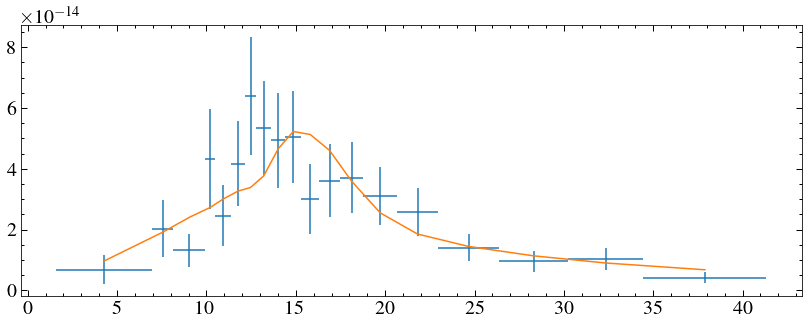

In [8]:
def xspec_to_spec(path):
    """
    Converts an xspec wdata textfile from counts to ergs. 
    Assumes that the wavelength array is in Angstrom and the flux arrays are in counts/s/cm2/A
    """
    xrt = np.loadtxt(path, skiprows=3)
    xrt = xrt[::-1]
    wx = xrt[:,0]*u.AA
    bx = xrt[:,1]*u.AA
    fx  = (xrt[:,2] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    ex  = (xrt[:,3] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
    if len(xrt[0]) == 5: #i.e. if there's a model
        mx  = (xrt[:,4] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
        return wx, bx, fx, ex, mx
    else:
        return wx, bx, fx, ex

xpath = '/media/david/2tb_ext_hd/hddata/ltt1445/swift/xrt/ltt1445B/ltt1445BC_xrt.txt'

wx, bx, fx, ex, mx = xspec_to_spec(xpath)


plt.errorbar(wx, fx, yerr=ex, xerr=bx, ls='none')
plt.plot(wx, mx)

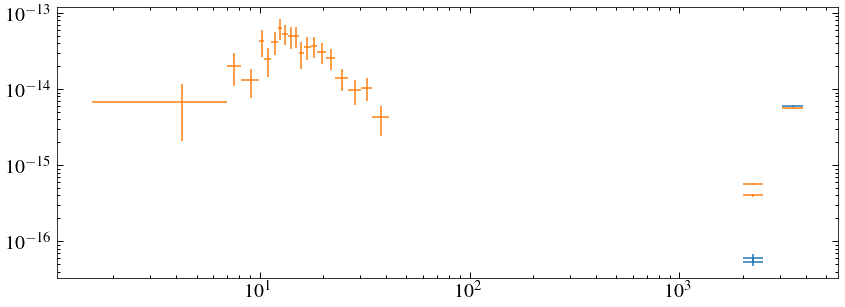

In [9]:
for phot in phots:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    c= 'C0'
    if 'BC' in os.path.split(phot)[1]:
        c='C1'
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, ls='none', c=c)

plt.errorbar(wx, fx, yerr=ex, xerr=bx, ls='none', c='C1')
plt.yscale('log')
plt.xscale('log')

In [10]:
import prepare_phoenix_svo as pp


In [11]:
p = 145.6917
d = (1000/p)*u.pc
print(d)

stars = ['LTT1445A', 'LTT1445B', 'LTT1445C']
teffs = [3337, 3150, 3060] #B+C teffs estimated from rochester tables
masses = [0.257,0.215,0.161]
radii = [0.268,0.236,0.197]

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)

repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'
save_path = 'phoenix_models/'

for i, star in enumerate(stars):
    g = (G*(masses[i]*M)/(radii[i]*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': teffs[i], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radii[i]*u.R_sun, 'Distance':d}

    # pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True)

6.863808988432423 pc


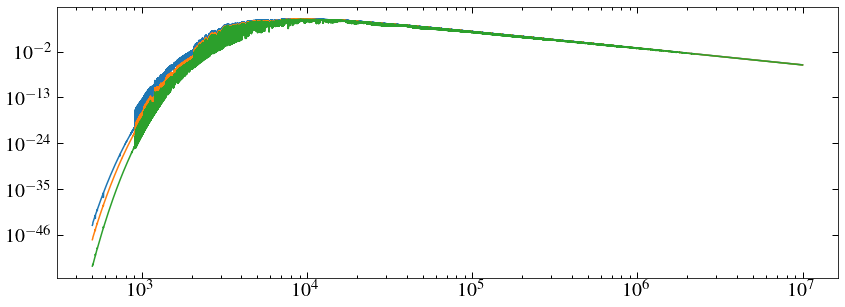

In [12]:
# for star in stars:
#     data = Table.read('phoenix_models/{}_phoenix_interpolated.ecsv'.format(star))
#     normfac=  data.meta['NORMFAC']
#     plt.plot(data['WAVELENGTH'], data['FLUX'])
    
# plt.yscale('log')
# plt.xscale('log')

In [13]:
phxA =  Table.read('phoenix_models/LTT1445A_phoenix_interpolated.ecsv')
wpA, fpA = phxA['WAVELENGTH'], phxA['FLUX']*phxA.meta['NORMFAC']
phxB =  Table.read('phoenix_models/LTT1445B_phoenix_interpolated.ecsv')
wpB, fpB = phxB['WAVELENGTH'], phxB['FLUX']*phxB.meta['NORMFAC']
phxC =  Table.read('phoenix_models/LTT1445C_phoenix_interpolated.ecsv')
wpC, fpC = phxC['WAVELENGTH'], phxC['FLUX']*phxC.meta['NORMFAC']

In [14]:
fpCi = interp1d(wpC, fpC, fill_value='extrapolate')(wpB)
fpBC = fpB+fpCi

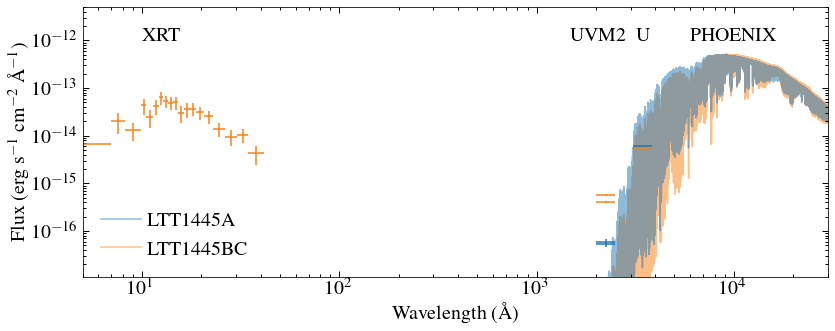

In [15]:
plt.figure(figsize=(12, 5))
for phot in phots:
    data = fits.getdata(phot, 1)
    w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
    f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
    c= 'C0'
    if 'BC' in os.path.split(phot)[1]:
        c='C1'
    plt.errorbar(w, f, yerr=e, xerr=fwhm/2, ls='none', c=c)
    
plt.plot(wpA, fpA, c='C0', zorder=-1, alpha=0.5, label = 'LTT1445A')
plt.plot(wpB, fpBC, c='C1', zorder=-2, alpha=0.5, label='LTT1445BC')


plt.errorbar(wx, fx, yerr=ex, xerr=bx, ls='none', c='C1')
plt.yscale('log')
plt.xscale('log')

plt.annotate('XRT', (10, 1e-12))
plt.annotate('UVM2', (2246-200, 1e-12), ha='center')
plt.annotate('U', (3465, 1e-12), ha='center')
plt.annotate('PHOENIX', (1e4, 1e-12), ha='center')

plt.ylim(1.1e-17, 0.5e-11)
plt.xlim(5, 3e4)
plt.legend(loc=3)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.savefig('plots/LTT1445_swift_sed.png', facecolor='w')
plt.savefig('plots/LTT1445_swift_sed.pdf')

Is the UVM2 higher for both at the same time

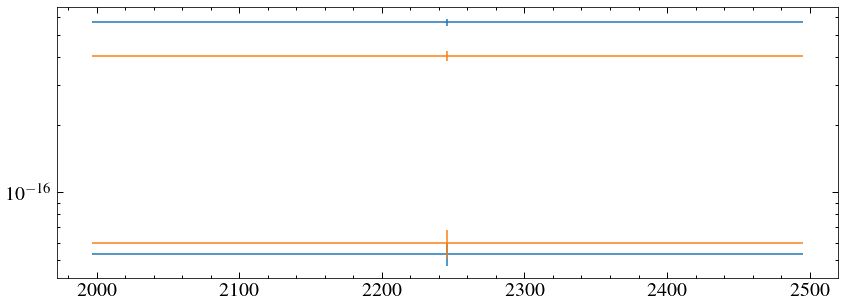

In [16]:
for phot in phots:
    data = fits.getdata(phot, 1)
    flt = data['FILTER'][0]
    if flt == 'UVM2':
        w, fwhm = cenwaves[data['FILTER'][0]], fwhms[data['FILTER'][0]]
        f, e = data['AB_FLUX_AA'], data['AB_FLUX_AA_ERR']
        c= 'C0'
        if 'obs2' in os.path.split(phot)[1]:
            c='C1'
        plt.errorbar(w, f, yerr=e, xerr=fwhm/2, ls='none', c=c)
plt.yscale('log')

In [17]:
lcs = glob.glob('{}*100slc*.fits'.format(path))
lcs

['/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445A_100slc_uvm2_obs2.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445A_100slc_u_obs3.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445BC_100slc_uvm2_obs2.fits',
 '/media/david/2tb_ext_hd/hddata/ltt1445/swift/uvot/working/ltt1445BC_100slc_u_obs3.fits']

(614087000.0, 614090000.0)

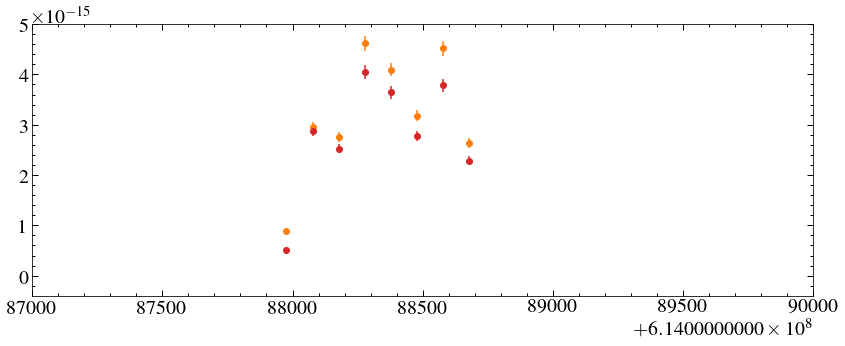

In [18]:
for lc in lcs:
    data = fits.getdata(lc, 1)
    plt.errorbar(data['TIME'], data['AB_FLUX_AA'], yerr = data['AB_FLUX_AA_ERR'], marker='o', ls='none')
# plt.xlim(65000+6.14e8, 67000+6.14e8)
plt.xlim(87000+6.14e8, 90000+6.14e8)
# plt.xlim()